In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your tar file in Google Drive
tar_path = '/content/drive/MyDrive/MLDATA/maps.tar.gz'

# Use shell command to extract the tar.gz file
!mkdir -p /content/maps
!tar -xvf '/content/drive/My Drive/MLDATA/maps.tar.gz' -C /content/

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

In [ ]:
from numpy import zeros, ones
from numpy.random import randint

# Use tensorflow.keras instead of keras for TensorFlow 2.x
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation,
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt  # Standard import for Matplotlib


In [ ]:
def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper

	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


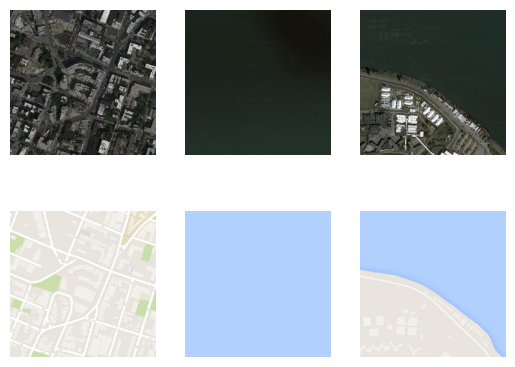

In [ ]:
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
data = [src_images, tar_images]
dataset = preprocess_data(data)

In [ ]:
from datetime import datetime
start1 = datetime.now()
train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1)
stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>10638, d1[0.473] d2[0.473] g[8.778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>10639, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>10640, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>10641, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>10642, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>10643, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>10644, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>10645, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>10646, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>10647, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>10648, d1[0.473] d2[0.473] g[8.778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>10649, d1[0.473] d2[0.473] g[8.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>10650, d1[0.473] d2[0.473] g[8.778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

>Saved: plot_010960.png and model_010960.h5
Execution time is:  0:33:24.786264


In [ ]:
g_model.save('generator_model.h5')

In [ ]:
from keras.models import load_model
from numpy.random import randint
model = load_model('/content/drive/MyDrive/MLDATA/generator_model.h5')

In [ ]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


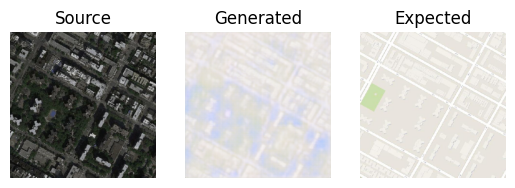

In [ ]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded:  (1098, 256, 256, 3) (1098, 256, 256, 3)


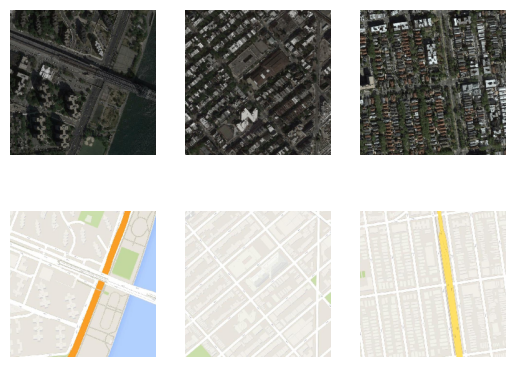

In [ ]:
#validation

valid_path= 'maps/val/'
# load dataset
[src_images, tar_images] = load_images(valid_path)
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
[src_images, tar_images] = preprocess_data([src_images, tar_images])

In [ ]:
import tensorflow as tf
l1_loss = tf.keras.losses.MeanAbsoluteError()

def evaluate_generator(generator, test_dataset):
    total_loss = 0.0
    count = 0

    for input_image, target_image in test_dataset:
        # Generate prediction
        generated_image = generator.predict(input_image)

        # Compute L1 loss
        loss = l1_loss(target_image, generated_image)
        total_loss += loss.numpy()
        count += 1
        print(f"Batch {count}: L1 Loss: {loss.numpy():.4f}")

    avg_l1_loss = total_loss / count
    print(f"Avg L1 Loss on Test Set: {avg_l1_loss:.4f}")
    return avg_l1_loss


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((src_images, tar_images)).batch(1)
evaluate_generator(model, test_dataset)

Batch 376: L1 Loss: 0.0618
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Batch 377: L1 Loss: 0.0833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Batch 378: L1 Loss: 0.0592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Batch 379: L1 Loss: 0.0586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
Batch 380: L1 Loss: 0.0610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Batch 381: L1 Loss: 0.1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Batch 382: L1 Loss: 0.0986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Batch 383: L1 Loss: 0.0802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Batch 384: L1 Loss: 0.0663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
Batch 385: L1 Loss: 0.0512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Batch 386: L1 Loss: 0.0759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Batch 387: L1 Loss: 0.0636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Batch 388: L1 Loss: 0.0664
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Batch 389: L1 Loss: 0.0779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Batch 390: L1 Loss: 0.0612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Batch 391:

np.float32(0.07797401)